In [1]:
from fklearn.training.classification import lgbm_classification_learner
from fklearn.validation.perturbators import perturbator, nullify, sample_columns
from fklearn.validation.validator import validator
from fklearn.validation.evaluators import auc_evaluator
from fklearn.validation.splitters import out_of_time_and_space_splitter
from fklearn.data.datasets import make_tutorial_data
from fklearn.training.transformation import onehot_categorizer 
from fklearn.preprocessing.splitting import space_time_split_dataset
from fklearn.training.pipeline import build_pipeline
from fklearn.training.imputation import imputer, placeholder_imputer
from toolz import compose
from datetime import datetime
from toolz import curry
import random
import pandas as pd
import os
random.seed(42)
os.environ['KMP_DUPLICATE_LIB_OK']='True' #some kernels die without this :sadpanda:

# Get the data

In [147]:
dataset = make_tutorial_data(50000)
dataset.head()

,id,date,feature1,feature2,feature3,target
0,id28,2015-04-04,11.516858,40.303827,a,45.307986
1,id55,2015-02-03,19.384250,39.316793,b,99.018120
2,id81,2015-03-06,19.390091,40.451471,c,70.051966
3,id12,2015-02-28,18.894861,40.996111,c,54.452913
4,id34,2015-01-08,19.934525,40.260577,b,97.801752


# Define a splitting fn

In [143]:
limit = pd.to_datetime("2015-03-01")

my_split_fn = out_of_time_and_space_splitter(n_splits = 2,
                                            in_time_limit=limit,
                                            time_column="date",
                                            space_column="id"
                                            )
folds, logs = my_split_fn(dataset)
[print(f"Fold {i} -- train: {len(fold[0])}, test: {len(fold[1][0])}") for i, fold in enumerate(folds)]

Fold 0 -- train: 14993, test: 9804
Fold 1 -- train: 15195, test: 10008


[None, None]

# Define impute fns

In [148]:
@curry
def get_first_out(df, learner):
    _, value, _ = learner(df)
    return value

num_inpute_learner = imputer(columns_to_impute=["feature1", "feature2"],
                             impute_strategy="median")

cat_inpute_learner = placeholder_imputer(columns_to_impute=["feature3"],
                                         placeholder_value="unk")

num_impute_fn = get_first_out(learner=num_inpute_learner)
cat_impute_fn = get_first_out(learner=cat_inpute_learner)

cat_impute_fn(dataset).head()

,id,date,feature1,feature2,feature3,target
0,id28,2015-04-04,11.516858,40.303827,a,45.307986
1,id55,2015-02-03,19.384250,39.316793,b,99.018120
2,id81,2015-03-06,19.390091,40.451471,c,70.051966
3,id12,2015-02-28,18.894861,40.996111,c,54.452913
4,id34,2015-01-08,19.934525,40.260577,b,97.801752


# Define oh encoder

In [149]:
oh_encode_learner = onehot_categorizer(columns_to_categorize=['feature3'],
                                       hardcode_nans=False,
                                       drop_first_column=True)

oh_encode_fn = get_first_out(learner=oh_encode_learner)


oh_encode_fn(dataset)

,id,date,feature1,feature2,target,feature3==b,feature3==c
0,id28,2015-04-04,11.516858,40.303827,45.307986,0,0
1,id55,2015-02-03,19.384250,39.316793,99.018120,1,0
2,id81,2015-03-06,19.390091,40.451471,70.051966,0,1
3,id12,2015-02-28,18.894861,40.996111,54.452913,0,1
4,id34,2015-01-08,19.934525,40.260577,97.801752,1,0
5,id52,2015-01-18,16.508868,40.073370,83.847147,1,0
6,id24,2015-04-03,22.298858,38.659626,98.449811,1,0
7,id22,2015-03-21,14.536496,38.744986,61.236455,0,1
8,id20,2015-01-08,17.152794,40.607559,87.429799,1,0
9,id11,2015-01-24,21.689982,39.067770,57.602847,0,0


# MSE vs Percentage of null columns 

In [156]:
def parse_metric(log, metric='mse_evaluator__target'):
    parsed = []
    for fold in log['validator_log']:
        parsed.append(fold['eval_results'][0][metric])
    return parsed

In [158]:
from tqdm import tqdm_notebook
import numpy as np

from fklearn.training.regression import lgbm_regression_learner
from fklearn.validation.evaluators import mse_evaluator

dataset = make_tutorial_data(50000) #just for reproducibility in cell
FEATURES = ['feature1', 'feature2', 'feature3==b', 'feature3==c']

train_fn = build_pipeline(
    lgbm_regression_learner(features=FEATURES, target='target'))

mse_eval_fn = mse_evaluator(prediction_column="prediction",
                          target_column="target")

preprocess_fn = compose(oh_encode_fn)

dataset = preprocess_fn(dataset)

In [ ]:
#TODO make it functional
RES = 4
RUNS_PER_RES = 20 
runs = []
threshs = np.linspace(0, 0.75, RES)
for thresh in tqdm_notebook(threshs):
    for i in range(RUNS_PER_RES):
        logs = []
        corr_cols = sample_columns(dataset[FEATURES], thresh)
        perturb_fn = perturbator(cols = corr_cols, corruption_fn = nullify())
        log = validator(dataset,
                      split_fn=my_split_fn,
                      train_fn=train_fn,
                      eval_fn=auc_eval_fn,
                      perturb_fn_train=perturb_fn)
        logs.append(log)
    runs.append(logs)

Since we have few features, the plot is too discrete and there's not much of a variance. But we can still see the metric degradation.

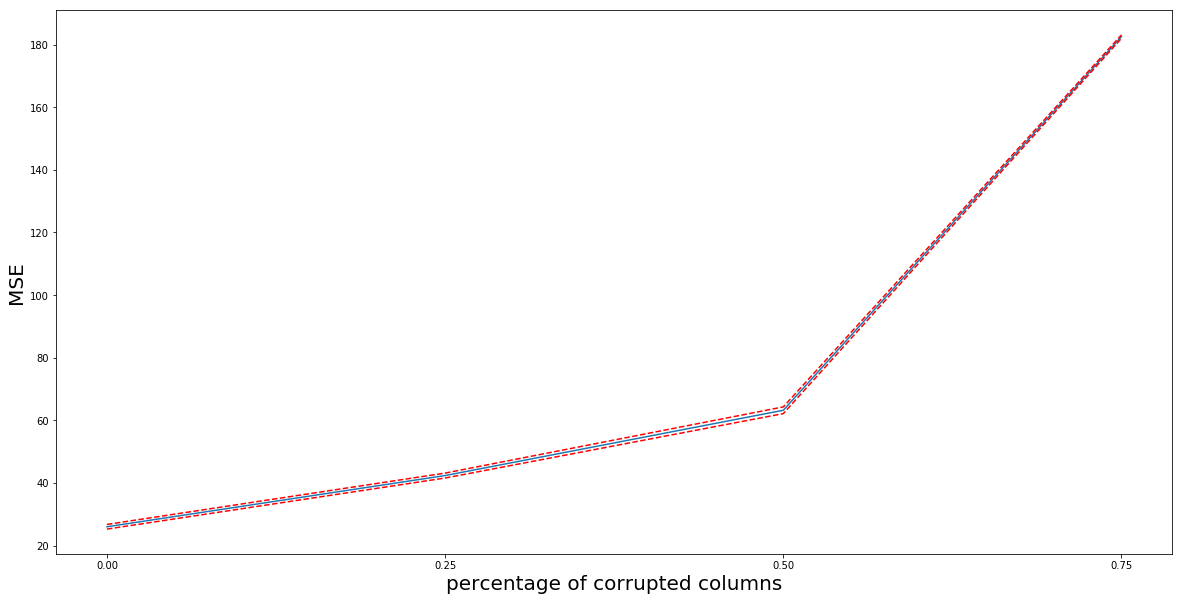

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline
means = []
stds = []

for thresh, run in zip(threshs, runs):
    metrics = []
    for sample in run:
        metrics += parse_metric(sample)
    stds.append(np.std(metrics))
    means.append(np.mean(metrics))
    
means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(20,10))

plt.plot(threshs, means)
plt.plot(threshs, means + 2*stds, 'r--')
plt.plot(threshs, means - 2*stds, 'r--')
plt.xlabel('percentage of corrupted columns', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(threshs)
plt.show()

# MSE vs Degree of corruption in N previously sampled columns


In [157]:
@curry
def run_experiment(dataset,
                  split_fn,
                  train_fn,
                  eval_fn,
                  corrupted_cols,
                  n_folds,
                  resolution):
    
    if isinstance(corrupted_cols, int):
        perc = corrupted_cols / len(FEATURES)
        corrupted_cols = sample_columns(dataset[FEATURES], perc)
    if isinstance(corrupted_cols, list): pass
    
    limit = pd.to_datetime("2015-03-01")
    my_split_fn = out_of_time_and_space_splitter(n_splits = n_folds,
                                                in_time_limit=limit,
                                                time_column="date",
                                                space_column="id"
                                                )

    corrupt_percs = np.linspace(0, 1, resolution)
    logs = []
    for corrupt_perc in tqdm_notebook(corrupt_percs):
        perturb_fn = perturbator(cols = corrupted_cols, corruption_fn = nullify(perc=corrupt_perc))
        log = validator(dataset,
                        split_fn=my_split_fn,
                        train_fn=train_fn,
                        eval_fn=auc_eval_fn,
                        perturb_fn_train=perturb_fn)
        logs.append(log)
    
    return logs

def get_statistics_logs(logs):
    metrics = [parse_metric(log) for log in logs]
    means = [np.mean(metric) for metric in metrics]
    stds = [np.std(metric) for metric in metrics]
    return np.array(means), np.array(stds)

def make_mean_std_plot(logs, ax=plt):
    means, stds = get_statistics_logs(logs)
    ax.plot(corrupt_percs, means)
    ax.plot(corrupt_percs, means + 2*stds, 'r--')
    ax.plot(corrupt_percs, means - 2*stds, 'r--')

In [122]:
NS = range(4)
experiment_fn = run_experiment(dataset=dataset,
               split_fn=my_split_fn,
               train_fn=train_fn,
               eval_fn=mse_eval_fn,
               corrupted_columns=2,
               n_folds=3,
               resolution=10)

all_logs = list(map(lambda x: experiment_fn(n_corrupted_cols=x), NS))

We expect the metric to deteriorate more with a bigger N:

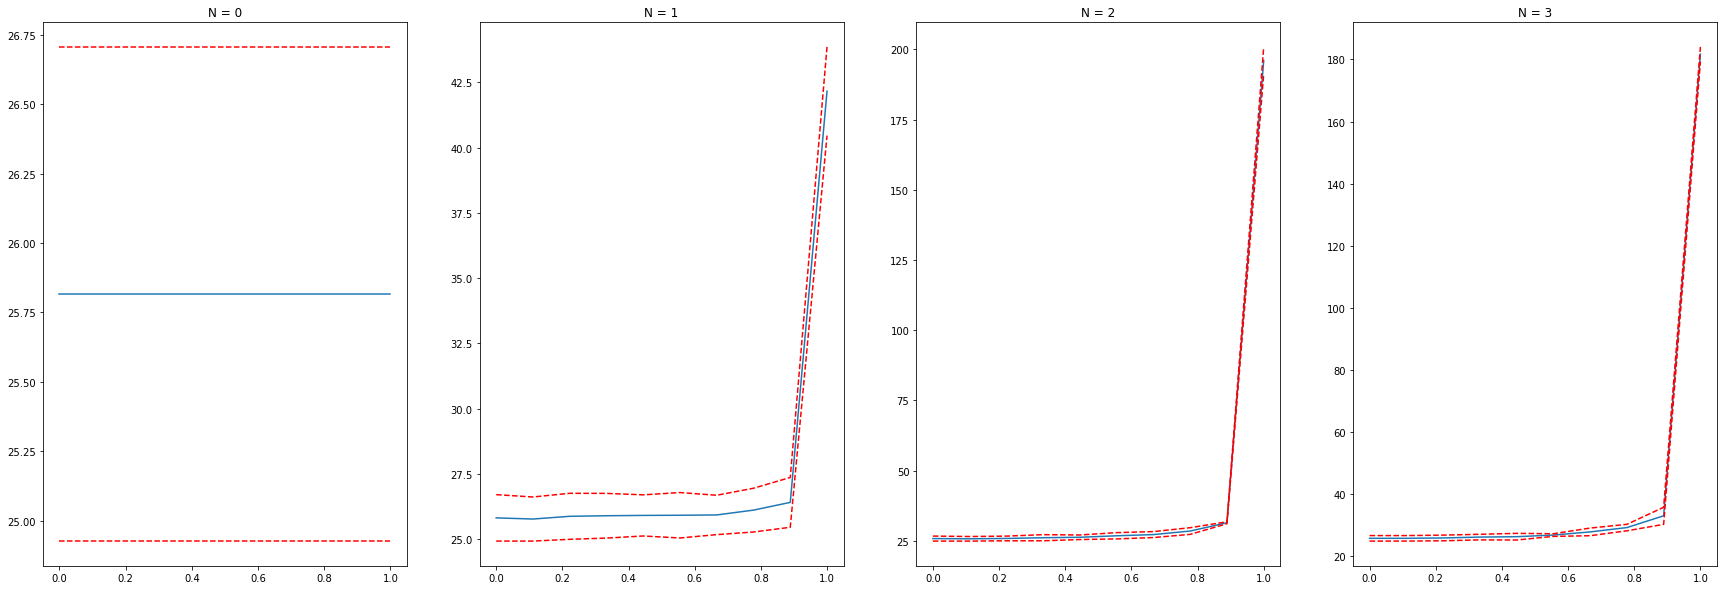

In [131]:
fig, axs = plt.subplots(1, 4, figsize=(30, 10))

for i, (ax, logs) in enumerate(zip(axs, all_logs)):
    ax.set_title(f'N = {i}')
    make_mean_std_plot(logs, ax=ax)

# But what if we fix N to 1 and vary the corrupted column? This might give us a grasp on how critical each feature is for the prediction

In [139]:
experiment_fn = run_experiment(dataset=dataset,
               split_fn=my_split_fn,
               train_fn=train_fn,
               eval_fn=mse_eval_fn,
#                corrupted_cols=2,
               n_folds=3,
               resolution=10)

all_logs = list(map(lambda x: experiment_fn(corrupted_cols=[x]), FEATURES))

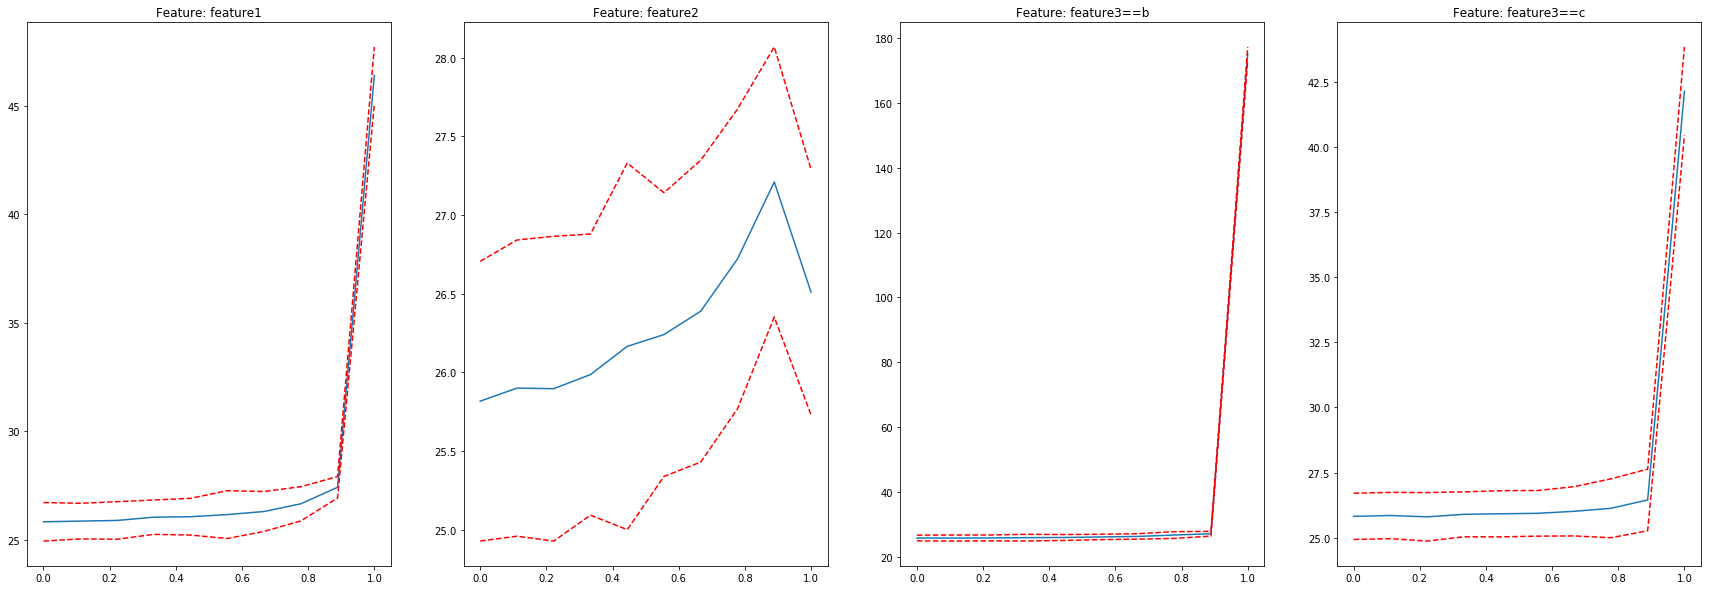

In [140]:
fig, axs = plt.subplots(1, 4, figsize=(30, 10))

for i, (ax, logs) in enumerate(zip(axs, all_logs)):
    ax.set_title(f'Feature: {FEATURES[i]}')
    make_mean_std_plot(logs, ax=ax)